<a href="https://colab.research.google.com/github/uu-sml/wasp-assigninmen-af-classification/blob/main/assignment_ecg_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WASP Course: Artificial Intelligence and Machine Learning

Lecturer: Thomas Schön

Assignment responsible: Antônio Horta Ribeiro, Carl Andersson, Daniel Gedon

---
# Module 3 - Assignment Overview: ECG classification

The [electrocardiogram (ECG)](https://www.mayoclinic.org/tests-procedures/ekg/about/pac-20384983) records the electrical signals in the heart. It is a common  test used to quickly detect heart problems and to monitor the heart's health. 
In this assignment you will implement and evaluate a model to classify whether the person has [atrial fibrillation (AF)](https://www.mayoclinic.org/diseases-conditions/atrial-fibrillation/symptoms-causes/syc-20350624.) or not based on measurements from the ECG exam. 


**Submission:** You submit the deliverables (see below) at <font color='red'>{TODO: where to submit}</font>

**Due Date:** June 15, 2022.

---
## Basic Tasks
Your task is to implement a classification model, train this model on the training data, and evaluate its performance on the validation data. We provide skeleton code for the implementation of a simple convolution neural network model.

The steps required to implement this model are presented as numbered tasks below. In total there are seven (7) coding tasks and five (5) explanation tasks. 

## Competitive setting

You have to compute the predictions for the test data (you do not have the labels for it) and submit your predictions to be evaluated. These predictions will be scored and your submission will be ranked according to the F1 score and compared with your colleagues. In the end a winning team will be determined.

### Deliverables
There are two deliverables:
1. You should have at least **three (3)** submissions (for instructions on how to submit, see the very end of this notebook) where you try to improve the model architecture, improve the training or the problem formulation. In the final delivery, you should provide a short explanation of what changed between each submission and justify why you decided to make these changes.
2. You have to submit this Jupyter notebook on the course web-page (Canvas) together with your code and explanations (where asked for it) that describe your implementation and your experimental results. The notebook should run as a standalone in google colab.

### Grading
To pass the assignment, you must submit a complete and working implementation of a model and a well-motivated description and evaluation of it. Your model should reach an Area under the ROC curve (AUROC) on the test data of at least 0.97 and an Average Precision (AP) score of 0.95. Note that the leaderboard to is sorted by F1 score and not AUROC/AP, hence you have to balance all three metrics.

### GPU Acceleration
To be able to use the GPUs provided by colab in order to speed up your computations, you have to set the `Hardware accelerator` to `GPU` under `Runtime > change runtime type`. Note that notebooks run by connecting to virtual machines that have maximum lifetimes that can be as much as 12 hours. Notebooks will also disconnect from VMs when left idle for too long. 

In [1]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
# Install packages
# !pip install wfdb xmljson matplotlib==3.3.4 ecg_plot 
# !pip install wfdb xmljson matplotlib==3.1.1 ecg_plot
!conda install -c conda-forge wfdb -y
!conda install -c gramener xmljson -y
!conda install matplotlib==3.1.1 -y
!pip install ecg_plot

Solving environment: done

# All requested packages already installed.

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: | 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
                                                                               failed

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - xmljson -> python[version='2.7.*|3.3.*|3.4.*|3.5.*']

Your python: python=3.8

If python is on the left-most side of the chain, that's the version you've asked for.
When python appears to the right, that indicates that the thing on the left is somehow
not available for th

In [3]:
# Import
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
import h5py
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

---
## The data set

The dataset you will use in this task is a subset of the so called [*CODE dataset*](https://scilifelab.figshare.com/articles/dataset/CODE_dataset/15169716): an anotated database of ECGs. The exams were taken in Brazil by the Telehealth Network of the state Minas Gerais between 2010 and 2016. The dataset and its usage for the development of deep learning methods was first described in the paper "Automatic diagnosis of the 12-lead ECG using a deep neural network". https://www.nature.com/articles/s41467-020-15432-4.
The data is openly available for research upon request and is [one of the largest datasets for developing deep-learning applications electrocardiography](https://www.nature.com/articles/s41569-020-00503-2/tables/1) .


In this case, you have only a subset of it. For the training dataset you have labels. We also provide a test dataset for which you do not have the labels.

Download the dataset from the given dropbox link and unzip the folder containing the files. The downloaded files are in WFDB format (see [here](https://www.physionet.org/content/wfdb-python/3.4.1/) for details).

In [4]:
# 1. Download dataset
!wget https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz -O codesubset.tar.gz

--2022-05-31 14:48:04--  https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6028:18::a27d:4712, 162.125.71.18
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6028:18::a27d:4712|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/9zkqa5y5jqakdil/codesubset.tar.gz [following]
--2022-05-31 14:48:04--  https://www.dropbox.com/s/raw/9zkqa5y5jqakdil/codesubset.tar.gz
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc583bae0b961f6e62e33c06d6ae.dl.dropboxusercontent.com/cd/0/inline/BmUydxl0E-gxkzYiyJZPEvdxuQX1I1jmSlvEkESjHjvOgjwmQ5_Mwb5I1Guhuf5jWlTtKYalqe21y_KNCar3gPnC8HOIJ9aeRAy2FFFdeEMGhD5ZNvnAXVJH_qDaVSCiav5TFjTLmT0hEdY6nf8yOWqK8O6sCp2-wswtvjzW8IMADa5O2kfkr4Tb3JNNcL7YeH4/file# [following]
--2022-05-31 14:48:05--  https://uc583bae0b961f6e62e33c06d6ae.dl.dropboxusercontent.com/cd/0/inline/BmUydxl0E-gxk

In [5]:
# 1. unzip the downloaded data set folder
!tar -xf codesubset.tar.gz


### Preprocessing

For the preprocessing we will use the GitHub repository: https://github.com/antonior92/ecg-preprocessing. 

Run the cells bellow to  Clone the GitHub repository for [data preprocessing](https://github.com/antonior92/ecg-preprocessing).


In [6]:
# 2. clone the code files for data preprocessing
!git clone https://github.com/antonior92/ecg-preprocessing.git

fatal: destination path 'ecg-preprocessing' already exists and is not an empty directory.


Let us plot an ECG sample. We can plot ECGs using the `ecg_plot` library for example by using the following code snippet where `ecg_sample` is an array of size `(number of leads X sequence length)`. Now we can view an ECG before preprocessing.

<Figure size 432x288 with 0 Axes>

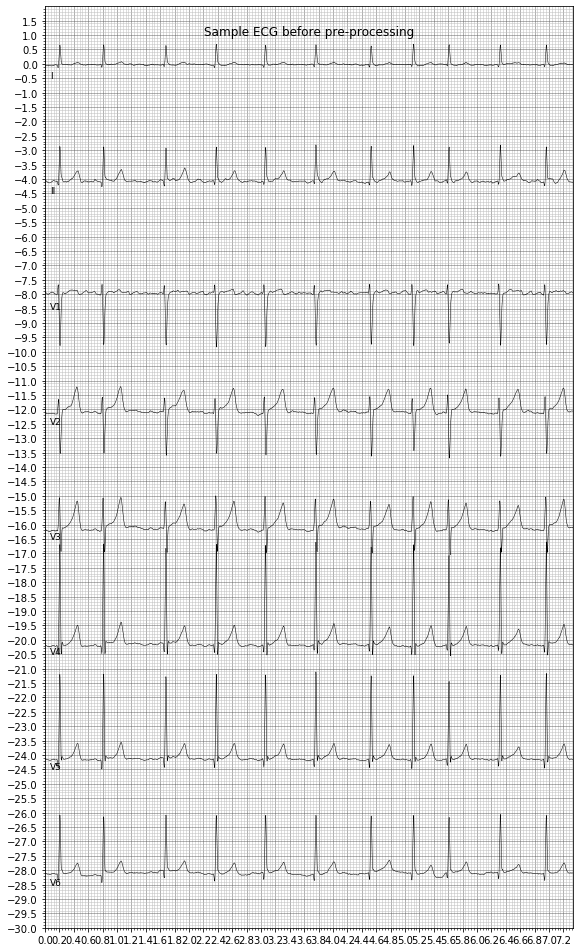

In [7]:
import ecg_plot
runfile("ecg-preprocessing/read_ecg.py")

PATH_TO_WFDB = 'codesubset/train/TNMG100046'
ecg_sample, sample_rate, _ = read_ecg(PATH_TO_WFDB)

# ECG plot
plt.figure()
lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(ecg_sample, sample_rate=sample_rate, style='bw', row_height=8, lead_index=lead, columns=1, title='Sample ECG before pre-processing')
plt.show()


The preprocessing consist of:
-  resampling all ECG traces to the sample sampling period (400 Hz). Option: ``--new_freq 400``
-  zero padding if necessary to the same number of samples (4096). Option: ``--new_len 4096``.
- removing trends in the ECG signal. Option: ``--remove_baseline``
- remove possible power line noise. Option: ``--powerline 60``

You can run the script bellow to plot the same ECG after the preprocessing.  The script also use the  `ecg_plot` library (as you did above).  You can try also with different command line options to see how the preprocessing affects the signal that will be used by the model.

Namespace(fmt='wfdb', new_freq=400.0, new_len=4096, path='codesubset/train/TNMG100046', powerline=60.0, remove_baseline=True, save='', scale=1, use_all_leads=False)


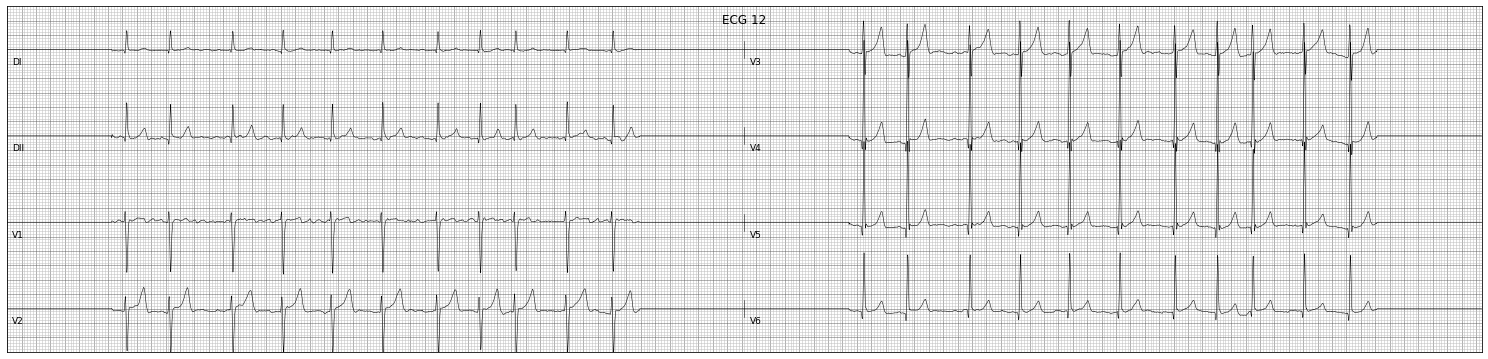

<Figure size 432x288 with 0 Axes>

In [8]:
%run ecg-preprocessing/plot_from_ecg.py codesubset/train/TNMG100046 --new_freq 400 --new_len 4096 --remove_baseline --powerline 60


Next we perform the preprocessing in all exams and convert them into one single h5 file (see [here](https://www.h5py.org/#:~:text=The%20h5py%20package%20is%20a,they%20were%20real%20NumPy%20arrays.) for details about the format). The resulting h5 files contains the traces as arrays with the shape `(number of traces x sequence length x number of leads)` where sequence length is 4096 and number of leads is 8. 
The files `train.h5` and `test.h5` will be saved inside the folder `codesubset/`.

In [9]:
# 3. Generate train
!python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/train/RECORDS.txt codesubset/train.h5
# 3. Generate test
!python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/test/RECORDS.txt codesubset/test.h5

Namespace(fmt='wfdb', input_file='codesubset/train/RECORDS.txt', new_freq=400.0, new_len=4096, out_file='codesubset/train.h5', powerline=60.0, remove_baseline=True, root_dir=None, scale=1, use_all_leads=False)
100%|████████████████████████████████████| 10000/10000 [00:38<00:00, 258.20it/s]
Namespace(fmt='wfdb', input_file='codesubset/test/RECORDS.txt', new_freq=400.0, new_len=4096, out_file='codesubset/test.h5', powerline=60.0, remove_baseline=True, root_dir=None, scale=1, use_all_leads=False)
100%|██████████████████████████████████████| 6000/6000 [00:24<00:00, 240.97it/s]


### Coding Task 1: Data Analysis

A first step before starting to model is always to analyse the data set. You can be creative in your way of *getting a feeling* for the data. What you have to do is:
- plot an ECG after proprocessing saved in the hdf5 file. For this use the `ecg_plot()` example above and see below for how to access the preprocessed data in h5 format.

Some further ideas to explore are:
- check the balance of the data set,
- evaluate the distribution of age and sex of the patients,
- think about the performance that a best naive classifier would achieve, e.g. by random guessing or always predicting one class.

<br />

**How to access the data?**

You can acces the data in the h5 file in the following way
```
import h5py

PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']
```
now `data[i]` is an numpy array of the $i$th ECG exam (all time points and leads for this one exam).


tracings
tracings
(4096, 8)


<Figure size 432x288 with 0 Axes>

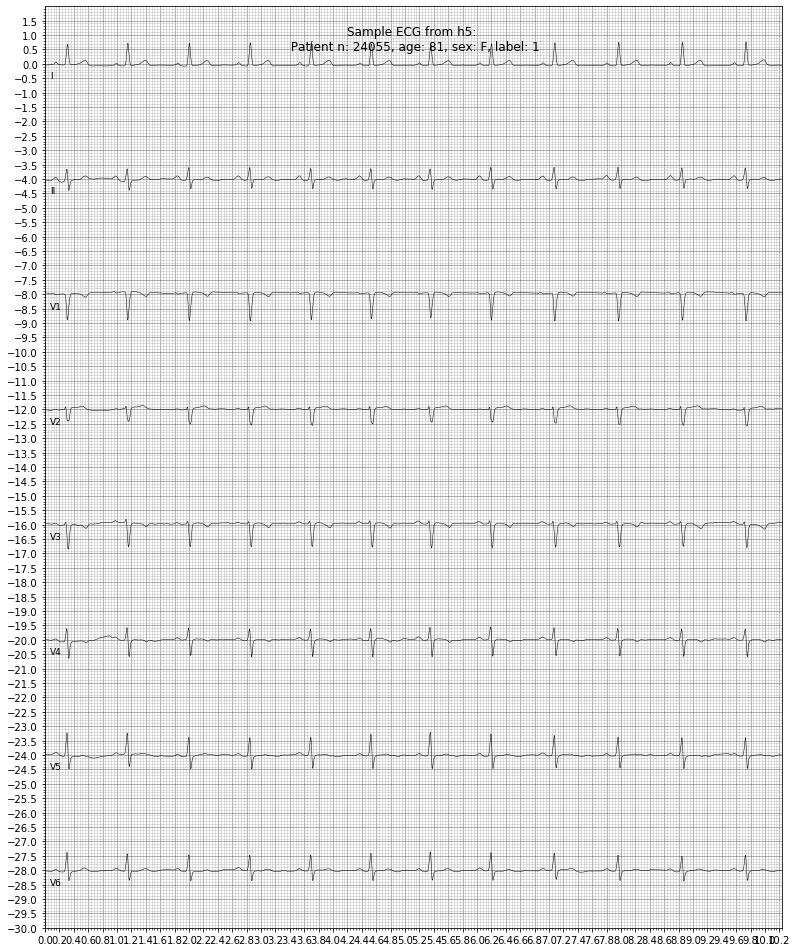

In [10]:
"""
TASK: Insert your code here
"""

import h5py
import pandas as pd
runfile("ecg-preprocessing/read_ecg.py")

PATH_TO_H5_FILE = 'codesubset/train.h5'
f= h5py.File(PATH_TO_H5_FILE, 'r')
path_to_csv_train = 'codesubset/train.csv'


for key in f.keys():
    print(key)
for _ in f:
    print(_)

# print(f.attrs)
data = f['tracings']

print(data[0].shape)

y = pd.read_csv(path_to_csv_train).to_dict('records')

# print(y)

#get a random sample of the data
i = np.random.randint(0, data.shape[0])


# ECG plot
plt.figure()
lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(data[i].T, sample_rate=400, style='bw', row_height=8, lead_index=lead, columns=1, title=f'Sample ECG from h5: \n Patient n: {y[i]["id_patient"]}, age: {y[i]["age"]}, sex: {y[i]["sex"]}, label: {y[i]["AF"]}')
# ecg_plot.plot(data[0], row_height=8, lead_index=lead, columns=1, title='Sample ECG from h5')
plt.show()
# print(data[0][0][:])
# ecg_plot.plot(data[0], sample_rate=sample_rate, style='bw', row_height=8, lead_index=lead, columns=1, title='Sample ECG after pre-processing')


### Explanation task 1: Data Analysis

Please explain your main findings of the data analysis task in a few bullet points. Explain also what the preprocessing does and why it is necessary:

<br />


**Your explantions here**

---
## Model

The model class consists of two methods: 
- `__init__(self, args)`: This methods initializes the class, e.g. by using `mymodel=ModelBaseline(args)`.
- `forward(self,input_data)`: This method is called when we run `model_output=mymodel(input_data)`.

The dimension of the input data is  `(batch size * sequence length * number of leads)`. Where **batch size** is a hyperparameter (usually power of 2), **sequence length** is the number of ECG samples in the time direction (=4096) and **number of leads** is self explanatory (=8).

The `ModelBaseline` that we provide below is a 2 layer model with one convolutional layers and one linear layer. 
- The conv layer downsamples the input traces from 4096 samples to 128 samples and increases the number of channels from 8 (=number of leads) to 32. Here we use a kernel size of 3.
- The linear layer uses the flattened output from the conv and outputs one prediction. Since we have a binary problem, a single prediction is sufficient.


In [11]:
class ModelBaseline(nn.Module):
    def __init__(self,):
        super(ModelBaseline, self).__init__()
        self.kernel_size = 3

        # conv layer
        downsample = self._downsample(4096, 128)
        self.conv1 = nn.Conv1d(in_channels=8, 
                               out_channels=32, 
                               kernel_size=self.kernel_size, 
                               stride=downsample,
                               padding=self._padding(downsample),
                               bias=False)
        
        # linear layer
        self.lin = nn.Linear(in_features=32*128,
                             out_features=1)
        
        # ReLU
        self.relu = nn.ReLU()

    def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)


    def forward(self, x):
        x= x.transpose(2,1)

        x = self.relu(self.conv1(x))
        x_flat= x.view(x.size(0), -1)
        x = self.lin(x_flat)

        return x

### Coding Task 2: Define your model

In the cell below you have to define your model. You can be inspired by the baseline model above but you can also define any other kind of neural network architecture.

In [12]:
class Model(nn.Module):
    # def __init__(self,):
    #     super(Model, self).__init__()
        
    # def forward(x):
    #     return
    def __init__(self,):
        super(ModelBaseline, self).__init__()
        self.kernel_size = 3

        # conv layer
        downsample = self._downsample(4096, 128)
        self.conv1 = nn.Conv1d(in_channels=8, 
                               out_channels=32, 
                               kernel_size=self.kernel_size, 
                               stride=downsample,
                               padding=self._padding(downsample),
                               bias=False)
        
        # linear layer
        self.lin = nn.Linear(in_features=32*128,
                             out_features=1)
        
        # ReLU
        self.relu = nn.ReLU()

    def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)


    def forward(self, x):
        x= x.transpose(2,1)

        x = self.relu(self.conv1(x))
        x_flat= x.view(x.size(0), -1)
        x = self.lin(x_flat)

        return x

### Explanation Task 2: Final Model
Please explain and motivate in short sentences or bullet points the choice of your final model.

<br />


**Your explantions here**


---
## Train function

The function `train(...)` is used to in every epoch to train the model. This is done by loading the training data, making predictions, comparing predictions with true labels in the loss function and adapting the model parameters using stochastic gradient descent.

In the code cell below there is the basic structure to load data from the data loader and to log your loss. The arguments of the function are explained by the use in the `main(...)` function below.

If you are unfamiliar with PyTorch training loops, then this official [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) might help (especially section "4. Train your Network").

### Coding Task 3: Fill training loop

Fill the code cell below such that the model is training when `train(...)` is called.

In [13]:
def train_loop(epoch, dataloader, model, optimizer, loss_function, device):
    # model to training mode
    model.train()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    # progress bar def
    train_pbar = tqdm(dataloader, desc="Training Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # training loop
    for traces, diagnoses in train_pbar:
        # data to device
        traces, diagnoses = traces.to(device), diagnoses.to(device)  # use cuda/GPUs if available

        """
        TASK: Insert your code here. This task can be done in 5 lines of code.
        """
        optimizer.zero_grad()
        output = model(traces)
        loss = loss_function(output, diagnoses)
        loss.backward()
        optimizer.step()
        
        

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        train_pbar.set_postfix({'loss': total_loss / n_entries})
    train_pbar.close()
    return total_loss / n_entries

---
##Eval function

The `eval(...)` function is similar to the `train(...)` function but is used to evaluate the model on validation data without adapting the model parameters. You can prohibit taking gradients by using a `with torch.no_grad():` statement.

Currenlty only the loss is logged here. Additionally you have to collect all your predictions and the true values in order to compute more metrics such as AUC.

### Coding Task 4: Fill evaluation loop
Fill the code cell below such we obtain model predictions to evaluate the validation loss and collect the predictoin in order to compute other validation metrics in the `main(...)` function.

In [24]:
def eval_loop(epoch, dataloader, model, loss_function, device):
    # model to validation mode
    model.eval()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    valid_pred, valid_true = [], []
    # progress bar def
    eval_pbar = tqdm(dataloader, desc="Evaluation Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # evaluation loop
    for traces_cpu, diagnoses_cpu in eval_pbar:
        # data to device
        traces, diagnoses = traces_cpu.to(device), diagnoses_cpu.to(device)

        """
        TASK: Insert your code here. This task can be done in 6 lines of code.
        """
        #TODO: Change this, not correct
        with torch.no_grad():
            output = model(traces)
            loss = loss_function(output, diagnoses)
            valid_pred.append(output.detach().cpu().numpy())
            # print(output.detach().cpu().numpy())
            for i in range(len(output)): 
                if output[i] == diagnoses[i]:
                    valid_true.append(1)
                else:
                    valid_true.append(0)
        
        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        eval_pbar.set_postfix({'loss': total_loss / n_entries})
    eval_pbar.close()
    return total_loss / n_entries, np.vstack(valid_pred), np.vstack(valid_true)

---
## Run Training

In the code cell below we give on top some initial training hyperparameters. Further, we combine everything from above into the training code. That means that we build the dataloaders, define the model/loss/optimizer and then train/validate the model over multiple epochs. 

Here we save the model with the lowest validation loss as the best model.

### Coding Task 5: Combine everything to train/validate the model

The following tasks are necessary in the code below
- split the data
- define the loss function
- decide and implement a validation metric to evaluate and compare the model on

Optional task:
- include learning rate scheduler
- take specific care about possible data inbalance

### Coding Task 6: Run your model and adapt hyperparameters

After you combined everything in task 4, here you run the model to tune and evaluate the training and model. For this you adapt 
- the training hyperparameters
- the model architecture
- the model hyperparameters \\
based on the resulting validation metrics.

### Explanation Task 3: Hyperparameter
Please explain and motivate in short sentences or bullet points the final choice of hyperparamer and how you developed them.

<br />


**Your explantions here**


In [15]:
# set seed
seed = 42 # <3
np.random.seed(seed)
torch.manual_seed(seed)

# choose variables
"""
TASK: Adapt the following hyperparameters if necessary
"""
learning_rate = 1e-2  
weight_decay = 1e-1  
num_epochs = 15
batch_size = 32

In [16]:
from torch.utils.data import TensorDataset, random_split, DataLoader

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tqdm.write("Use device: {device:}\n".format(device=device))

# =============== Build data loaders ======================================#
tqdm.write("Building data loaders...")

path_to_h5_train, path_to_csv_train, path_to_records = 'codesubset/train.h5', 'codesubset/train.csv', 'codesubset/train/RECORDS.txt'
# load traces
#traces = torch.tensor(h5py.File(path_to_h5_train, 'r')['tracings'], dtype=torch.float32)
# load labels
ids_traces = [int(x.split('TNMG')[1]) for x in list(pd.read_csv(path_to_records, header=None)[0])] # Get order of ids in traces
df = pd.read_csv(path_to_csv_train)
df.set_index('id_exam', inplace=True)
df = df.reindex(ids_traces) # make sure the order is the same
labels = torch.tensor(np.array(df['AF']), dtype=torch.float32).reshape(-1,1)
# load dataset
traces = torch.tensor(h5py.File(path_to_h5_train, 'r')['tracings'], dtype=torch.float32)
dataset = TensorDataset(traces, labels)
len_dataset = len(dataset)
n_classes = len(torch.unique(labels))
# split data
"""
TASK: Split the dataset in train and validation; Insert your code here.
This can be done in <=4 line of code
"""

val_length = int(len(dataset)*0.3)
dataset_train, dataset_valid = torch.utils.data.random_split(dataset, [len(dataset)-val_length, val_length])

print(len(dataset_train), len(dataset_valid))

# build data loaders
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)                         
tqdm.write("Done!\n")

Use device: cpu

Building data loaders...
7000 3000
Done!



/var/folders/bl/njr8z_xd1x72gplsvwnvybgc0000gn/T/ipykernel_94907/2665784430.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_croot-udngs7fm/pytorch_1648016055234/work/torch/csrc/utils/tensor_new.cpp:201.)
  traces = torch.tensor(h5py.File(path_to_h5_train, 'r')['tracings'], dtype=torch.float32)


In [25]:
import sklearn.metrics as skl_metrics                                  #### REMOVE LATER ON

# =============== Define model ============================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
model = ModelBaseline()
model.to(device=device)
tqdm.write("Done!\n")

# =============== Define loss function ====================================#
"""
TASK: define the loss; Insert your code here. This can be done in 1 line of code
"""
loss_function = torch.nn.BCEWithLogitsLoss()

# =============== Define optimizer ========================================#
tqdm.write("Define optimiser...")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
tqdm.write("Done!\n")

# =============== Define lr scheduler =====================================#
# TODO advanced students (non mandatory)
"""
OPTIONAL: define a learning rate scheduler; Insert your code here
"""
lr_scheduler = None

# =============== Train model =============================================#
tqdm.write("Training...")
best_loss = np.Inf
# allocation
train_loss_all, valid_loss_all = [], []

# loop over epochs
for epoch in range(1, num_epochs + 1):
    # training loop
    train_loss = train_loop(epoch, train_dataloader, model, optimizer, loss_function, device)
    # validation loop
    valid_loss, y_pred, y_true = eval_loop(epoch, valid_dataloader, model, loss_function, device)

    # collect losses
    train_loss_all.append(train_loss)
    valid_loss_all.append(valid_loss)

    # compute validation metrics for performance evaluation
    """
    TASK: compute validation metrics (e.g. AUC); Insert your code here
    This can be done e.g. in 5 lines of code
    """
    

    # save best model: here we save the model only for the lowest validation loss
    if valid_loss < best_loss:
        # Save model parameters
        torch.save({'model': model.state_dict()}, 'model.pth') 
        # Update best validation loss
        best_loss = valid_loss
        # statement
        model_save_state = "Best model -> saved"
    else:
        model_save_state = ""

    # Print message
    tqdm.write('Epoch {epoch:2d}: \t'
                'Train Loss {train_loss:.6f} \t'
                'Valid Loss {valid_loss:.6f} \t'
                '{model_save}'
                .format(epoch=epoch,
                        train_loss=train_loss,
                        valid_loss=valid_loss,
                        model_save=model_save_state)
                    )

    # Update learning rate with lr-scheduler
    if lr_scheduler:
        lr_scheduler.step()

"""
TASK: Here it can make sense to plot your learning curve; Insert your code here
"""

Define model...
Done!

Define optimiser...
Done!

Training...


Training Epoch  1:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/94 [00:00<?, ?it/s]

[[-0.57739526]
 [-0.57660013]
 [-0.58605945]
 [-0.58077425]
 [-0.56885624]
 [-0.5725832 ]
 [-0.5732095 ]
 [-0.6271082 ]
 [-0.5936683 ]
 [-0.5703642 ]
 [-0.5778127 ]
 [-0.566998  ]
 [-0.58262026]
 [-0.5853841 ]
 [-0.5805321 ]
 [-0.5694571 ]
 [-0.5900427 ]
 [-0.56499577]
 [-0.571092  ]
 [-0.577601  ]
 [-0.57066065]
 [-0.57335657]
 [-0.58495045]
 [-0.576152  ]
 [-0.5821754 ]
 [-0.56691825]
 [-0.5816554 ]
 [-0.5704086 ]
 [-0.56842625]
 [-0.56349444]
 [-0.5915698 ]
 [-0.5652365 ]]
[[-0.5658536 ]
 [-0.567187  ]
 [-0.56525004]
 [-0.5720844 ]
 [-0.56480867]
 [-0.56963116]
 [-0.561012  ]
 [-0.58169657]
 [-0.57231754]
 [-0.56650054]
 [-0.5771813 ]
 [-0.57278246]
 [-0.5744573 ]
 [-0.57597506]
 [-0.5618072 ]
 [-0.5712483 ]
 [-0.5662096 ]
 [-0.5731782 ]
 [-0.5746361 ]
 [-0.5650603 ]
 [-0.5801101 ]
 [-0.56135833]
 [-0.5823621 ]
 [-0.5675371 ]
 [-0.56495535]
 [-0.56951725]
 [-0.56938577]
 [-0.5747093 ]
 [-0.573209  ]
 [-0.56919634]
 [-0.5640688 ]
 [-0.57619077]]
[[-0.5789163 ]
 [-0.5848091 ]
 [-0.561

Training Epoch  2:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/94 [00:00<?, ?it/s]

[[-0.611353  ]
 [-0.5881866 ]
 [-0.600062  ]
 [-0.5880582 ]
 [-0.58048093]
 [-0.57976604]
 [-0.5896659 ]
 [-0.5681479 ]
 [-0.5978003 ]
 [-0.58653545]
 [-0.60277563]
 [-0.5832839 ]
 [-0.5977427 ]
 [-0.58908916]
 [-0.5972007 ]
 [-0.5813852 ]
 [-0.60112476]
 [-0.5762989 ]
 [-0.5877677 ]
 [-0.5888594 ]
 [-0.5822632 ]
 [-0.5799808 ]
 [-0.59267104]
 [-0.58782035]
 [-0.5829125 ]
 [-0.5735528 ]
 [-0.583656  ]
 [-0.5832341 ]
 [-0.5740252 ]
 [-0.5694203 ]
 [-0.5880072 ]
 [-0.56989944]]
[[-0.57632256]
 [-0.5870725 ]
 [-0.5745612 ]
 [-0.59119827]
 [-0.5721439 ]
 [-0.58795345]
 [-0.5731003 ]
 [-0.5925237 ]
 [-0.5837969 ]
 [-0.57892156]
 [-0.59513843]
 [-0.57618916]
 [-0.584284  ]
 [-0.588121  ]
 [-0.57936937]
 [-0.57514685]
 [-0.5812439 ]
 [-0.58711517]
 [-0.58235675]
 [-0.5668085 ]
 [-0.59055835]
 [-0.57192796]
 [-0.58657795]
 [-0.5807141 ]
 [-0.58040076]
 [-0.58549   ]
 [-0.58784306]
 [-0.5815131 ]
 [-0.5869128 ]
 [-0.58827066]
 [-0.5751153 ]
 [-0.5949838 ]]
[[-0.5935843 ]
 [-0.60329396]
 [-0.569

Training Epoch  3:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/94 [00:00<?, ?it/s]

[[-0.7627592 ]
 [-0.6532654 ]
 [-0.9136326 ]
 [-0.8380567 ]
 [-0.6790451 ]
 [-0.7970284 ]
 [-0.7221779 ]
 [-1.2010832 ]
 [-0.9460464 ]
 [-0.76343334]
 [-0.75017655]
 [-0.7342828 ]
 [-0.81573045]
 [-0.8121221 ]
 [-0.89504284]
 [-0.82004535]
 [-0.9457935 ]
 [-0.70044225]
 [-0.7519114 ]
 [-0.81505567]
 [-0.7663845 ]
 [-0.8483857 ]
 [-0.89556086]
 [-0.6791451 ]
 [-0.781597  ]
 [-0.6927473 ]
 [-0.85221946]
 [-0.7267528 ]
 [-0.71633977]
 [-0.65651596]
 [-0.8315449 ]
 [-0.65923154]]
[[-0.67888665]
 [-0.7440591 ]
 [-0.676315  ]
 [-0.7331368 ]
 [-0.69095296]
 [-0.7420698 ]
 [-0.7008953 ]
 [-0.71097875]
 [-0.70762646]
 [-0.70769477]
 [-0.68150085]
 [-0.73813605]
 [-0.7242868 ]
 [-0.7811136 ]
 [-0.6708932 ]
 [-0.73207116]
 [-0.712016  ]
 [-0.74197257]
 [-0.77895516]
 [-0.72092545]
 [-0.7999003 ]
 [-0.65439636]
 [-0.7859545 ]
 [-0.7390125 ]
 [-0.7054847 ]
 [-0.6830278 ]
 [-0.71340656]
 [-0.65273964]
 [-0.7077141 ]
 [-0.7382457 ]
 [-0.7165334 ]
 [-0.7962489 ]]
[[-0.79998934]
 [-0.8858352 ]
 [-0.622

Training Epoch  4:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/94 [00:00<?, ?it/s]

[[-0.7324702 ]
 [-0.68482494]
 [-0.7841835 ]
 [-0.7354002 ]
 [-0.6811774 ]
 [-0.6912295 ]
 [-0.6697713 ]
 [-0.97554183]
 [-0.70288265]
 [-0.7286277 ]
 [-0.73748475]
 [-0.69105077]
 [-0.75418186]
 [-0.787694  ]
 [-0.7990086 ]
 [-0.6781954 ]
 [-0.8129897 ]
 [-0.65345615]
 [-0.70192754]
 [-0.7067882 ]
 [-0.71536195]
 [-0.7549838 ]
 [-0.76071554]
 [-0.7069825 ]
 [-0.67210144]
 [-0.6690939 ]
 [-0.7717272 ]
 [-0.66417056]
 [-0.706288  ]
 [-0.627937  ]
 [-0.8587962 ]
 [-0.616851  ]]
[[-0.6565094 ]
 [-0.65252256]
 [-0.6632584 ]
 [-0.68239677]
 [-0.63268614]
 [-0.68358135]
 [-0.6206451 ]
 [-0.7638289 ]
 [-0.690794  ]
 [-0.6261127 ]
 [-0.75503397]
 [-0.6785177 ]
 [-0.7364821 ]
 [-0.72188276]
 [-0.62404704]
 [-0.6829432 ]
 [-0.7134452 ]
 [-0.6936173 ]
 [-0.6780938 ]
 [-0.6422917 ]
 [-0.7677686 ]
 [-0.60231966]
 [-0.77265835]
 [-0.6622943 ]
 [-0.6601516 ]
 [-0.69084895]
 [-0.6778833 ]
 [-0.7143344 ]
 [-0.69979167]
 [-0.7053651 ]
 [-0.6817789 ]
 [-0.6881096 ]]
[[-0.7649556 ]
 [-0.71798885]
 [-0.615

Training Epoch  5:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/94 [00:00<?, ?it/s]

[[-0.7110097 ]
 [-0.7642449 ]
 [-0.7436135 ]
 [-0.6843423 ]
 [-0.67268527]
 [-0.79685557]
 [-0.7188554 ]
 [-0.9922337 ]
 [-1.0346203 ]
 [-0.653998  ]
 [-0.7564387 ]
 [-0.6979083 ]
 [-0.80493987]
 [-0.89834136]
 [-0.7264621 ]
 [-0.68934023]
 [-0.7853192 ]
 [-0.69512093]
 [-0.7003918 ]
 [-0.63326144]
 [-0.7446956 ]
 [-0.678584  ]
 [-0.73507977]
 [-0.69104743]
 [-0.82880765]
 [-0.6336056 ]
 [-0.7465262 ]
 [-0.6518202 ]
 [-0.8258282 ]
 [-0.9143542 ]
 [-0.7903974 ]
 [-0.6570092 ]]
[[-0.6342558 ]
 [-0.67102855]
 [-0.6366153 ]
 [-0.7646595 ]
 [-0.6226111 ]
 [-0.6815918 ]
 [-0.6505014 ]
 [-0.75898993]
 [-0.7128475 ]
 [-0.74027985]
 [-0.653121  ]
 [-0.65244234]
 [-0.7456012 ]
 [-0.71221983]
 [-0.6281701 ]
 [-0.7374382 ]
 [-0.6425963 ]
 [-0.729668  ]
 [-0.7721727 ]
 [-0.64871   ]
 [-0.72149885]
 [-0.63463914]
 [-0.79185486]
 [-0.6266165 ]
 [-0.7255146 ]
 [-0.6644176 ]
 [-0.68331176]
 [-0.65499556]
 [-0.769115  ]
 [-0.69232225]
 [-0.6432725 ]
 [-0.64549387]]
[[-0.6942798 ]
 [-1.0774908 ]
 [-0.591

Training Epoch  6:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/94 [00:00<?, ?it/s]

[[-0.78598064]
 [-0.8524551 ]
 [-1.0153811 ]
 [-0.8564128 ]
 [-0.7327611 ]
 [-0.7937486 ]
 [-0.7245003 ]
 [-1.201896  ]
 [-0.991788  ]
 [-0.74838316]
 [-0.90577257]
 [-0.79767764]
 [-0.8342871 ]
 [-0.93221533]
 [-0.9074364 ]
 [-0.79386765]
 [-0.8442301 ]
 [-0.72443014]
 [-0.833603  ]
 [-0.9221596 ]
 [-0.7311486 ]
 [-0.7457671 ]
 [-1.1344328 ]
 [-0.78331625]
 [-0.786952  ]
 [-0.6989715 ]
 [-0.92331284]
 [-0.75940204]
 [-0.73462266]
 [-0.65789855]
 [-0.7997105 ]
 [-0.65910137]]
[[-0.6281085 ]
 [-0.7158369 ]
 [-0.7209023 ]
 [-0.8288519 ]
 [-0.68873537]
 [-0.84104615]
 [-0.69951415]
 [-0.9378584 ]
 [-0.76582575]
 [-0.69784015]
 [-0.8321621 ]
 [-0.78470814]
 [-0.818571  ]
 [-0.80309445]
 [-0.65047044]
 [-0.7114204 ]
 [-0.8071271 ]
 [-0.7776358 ]
 [-0.754404  ]
 [-0.7937007 ]
 [-0.8960259 ]
 [-0.6415217 ]
 [-0.8601711 ]
 [-0.75771904]
 [-0.72617215]
 [-0.751437  ]
 [-0.70388603]
 [-0.8300769 ]
 [-0.7270736 ]
 [-0.74133193]
 [-0.71881187]
 [-0.9444329 ]]
[[-0.87113196]
 [-1.1702279 ]
 [-0.631

Training Epoch  7:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/94 [00:00<?, ?it/s]

[[-0.67673635]
 [-0.6780435 ]
 [-0.7233407 ]
 [-0.65240836]
 [-0.6175699 ]
 [-0.64052993]
 [-0.6391376 ]
 [-1.016592  ]
 [-0.7040013 ]
 [-0.6172699 ]
 [-0.6899099 ]
 [-0.6357691 ]
 [-0.661951  ]
 [-0.6688398 ]
 [-0.67115873]
 [-0.66237074]
 [-0.8280517 ]
 [-0.5999766 ]
 [-0.6651233 ]
 [-0.66276246]
 [-0.6309329 ]
 [-0.6770822 ]
 [-0.6880988 ]
 [-0.66804194]
 [-0.6081058 ]
 [-0.61023635]
 [-0.6765326 ]
 [-0.65653795]
 [-0.6469161 ]
 [-0.6014095 ]
 [-0.6867635 ]
 [-0.6072143 ]]
[[-0.64222085]
 [-0.622693  ]
 [-0.5877699 ]
 [-0.6605864 ]
 [-0.61131954]
 [-0.64370424]
 [-0.60954404]
 [-0.662055  ]
 [-0.6377491 ]
 [-0.61824346]
 [-0.6679568 ]
 [-0.63715994]
 [-0.641646  ]
 [-0.6472117 ]
 [-0.60701835]
 [-0.61339694]
 [-0.6387992 ]
 [-0.6578003 ]
 [-0.6709076 ]
 [-0.6348257 ]
 [-0.6786594 ]
 [-0.6046163 ]
 [-0.6652663 ]
 [-0.6309562 ]
 [-0.6249539 ]
 [-0.63712925]
 [-0.6219563 ]
 [-0.6582726 ]
 [-0.6354188 ]
 [-0.62191516]
 [-0.6266034 ]
 [-0.6849025 ]]
[[-0.6653897 ]
 [-0.6100872 ]
 [-0.600

Training Epoch  8:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/94 [00:00<?, ?it/s]

[[-0.54581547]
 [-0.541847  ]
 [-0.54133654]
 [-0.5384229 ]
 [-0.5481219 ]
 [-0.54024607]
 [-0.527499  ]
 [-0.45637304]
 [-0.5502118 ]
 [-0.55266243]
 [-0.544482  ]
 [-0.5463128 ]
 [-0.5405113 ]
 [-0.52107894]
 [-0.54352236]
 [-0.5487828 ]
 [-0.47614843]
 [-0.542832  ]
 [-0.55543226]
 [-0.5491926 ]
 [-0.5360126 ]
 [-0.5341649 ]
 [-0.5414889 ]
 [-0.5441581 ]
 [-0.55326355]
 [-0.54102963]
 [-0.54325074]
 [-0.5411459 ]
 [-0.5234288 ]
 [-0.5624931 ]
 [-0.5406843 ]
 [-0.5425708 ]]
[[-0.54205185]
 [-0.53630716]
 [-0.5490649 ]
 [-0.54706496]
 [-0.5484539 ]
 [-0.5497018 ]
 [-0.55134064]
 [-0.54804087]
 [-0.54233944]
 [-0.5440623 ]
 [-0.54042214]
 [-0.5407241 ]
 [-0.5563134 ]
 [-0.54437375]
 [-0.5470614 ]
 [-0.53649235]
 [-0.5473672 ]
 [-0.54480773]
 [-0.5401147 ]
 [-0.5419142 ]
 [-0.5413132 ]
 [-0.54604805]
 [-0.5310736 ]
 [-0.54259473]
 [-0.54794246]
 [-0.5474506 ]
 [-0.5632327 ]
 [-0.5395167 ]
 [-0.54227155]
 [-0.5399527 ]
 [-0.54870737]
 [-0.5581622 ]]
[[-0.53557485]
 [-0.5540174 ]
 [-0.547

Training Epoch  9:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/94 [00:00<?, ?it/s]

[[-0.70763916]
 [-0.65801346]
 [-0.58797324]
 [-0.7077936 ]
 [-0.62265253]
 [-0.6817832 ]
 [-0.68896157]
 [-0.72541773]
 [-0.81495726]
 [-0.56611586]
 [-0.64760756]
 [-0.60372657]
 [-0.6817282 ]
 [-0.6821789 ]
 [-0.63375443]
 [-0.60171217]
 [-0.70313805]
 [-0.59965426]
 [-0.54227746]
 [-0.6157899 ]
 [-0.6017168 ]
 [-0.6559614 ]
 [-0.7549    ]
 [-0.62727714]
 [-0.6597431 ]
 [-0.6030891 ]
 [-0.6749892 ]
 [-0.6644771 ]
 [-0.6251674 ]
 [-0.58242434]
 [-0.6874509 ]
 [-0.57409763]]
[[-0.5974054 ]
 [-0.6041975 ]
 [-0.6122702 ]
 [-0.5984534 ]
 [-0.6070584 ]
 [-0.6732063 ]
 [-0.6214874 ]
 [-0.73418885]
 [-0.6392896 ]
 [-0.6020966 ]
 [-0.64932364]
 [-0.6429497 ]
 [-0.6363634 ]
 [-0.6545361 ]
 [-0.5625292 ]
 [-0.57751757]
 [-0.6196825 ]
 [-0.6622818 ]
 [-0.65544283]
 [-0.6392398 ]
 [-0.6548928 ]
 [-0.6068803 ]
 [-0.6523464 ]
 [-0.58955985]
 [-0.60525686]
 [-0.6234002 ]
 [-0.58887595]
 [-0.61418504]
 [-0.61353374]
 [-0.6049859 ]
 [-0.60777575]
 [-0.64847404]]
[[-0.65449107]
 [-0.71742624]
 [-0.581

Training Epoch 10:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/94 [00:00<?, ?it/s]

[[-0.5437098 ]
 [-0.5733565 ]
 [-0.6488726 ]
 [-0.621506  ]
 [-0.56168556]
 [-0.5397633 ]
 [-0.5411885 ]
 [-0.9205304 ]
 [-0.590705  ]
 [-0.54757005]
 [-0.5784577 ]
 [-0.5757679 ]
 [-0.64602137]
 [-0.5643463 ]
 [-0.60912365]
 [-0.5920337 ]
 [-1.0846376 ]
 [-0.5712325 ]
 [-0.6122065 ]
 [-0.589782  ]
 [-0.5569035 ]
 [-0.5603624 ]
 [-0.6147314 ]
 [-0.63131183]
 [-0.50507617]
 [-0.5607618 ]
 [-0.53999335]
 [-0.5956121 ]
 [-0.6490767 ]
 [-0.5307959 ]
 [-0.57598925]
 [-0.53900504]]
[[-0.5729352 ]
 [-0.5283818 ]
 [-0.5245739 ]
 [-0.56576747]
 [-0.54043937]
 [-0.6315914 ]
 [-0.5013591 ]
 [-0.70334315]
 [-0.54658026]
 [-0.5516854 ]
 [-0.63381505]
 [-0.5548651 ]
 [-0.51473475]
 [-0.55073744]
 [-0.5404539 ]
 [-0.54374206]
 [-0.5841688 ]
 [-0.59151506]
 [-0.5599926 ]
 [-0.5584724 ]
 [-0.64847696]
 [-0.5469729 ]
 [-0.58391017]
 [-0.55630827]
 [-0.56547457]
 [-0.54482514]
 [-0.6222088 ]
 [-0.5956876 ]
 [-0.54964644]
 [-0.5408304 ]
 [-0.5667778 ]
 [-0.59015083]]
[[-0.6232073 ]
 [-0.5579128 ]
 [-0.533

Training Epoch 11:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/94 [00:00<?, ?it/s]

[[-0.5324475 ]
 [-0.5385613 ]
 [-0.49296498]
 [-0.53652495]
 [-0.5496303 ]
 [-0.5165147 ]
 [-0.5348081 ]
 [-0.56647664]
 [-0.54896575]
 [-0.53303635]
 [-0.5385214 ]
 [-0.5192027 ]
 [-0.5332091 ]
 [-0.5571226 ]
 [-0.5302707 ]
 [-0.5830169 ]
 [-0.54200226]
 [-0.5382573 ]
 [-0.5388733 ]
 [-0.5313786 ]
 [-0.51918185]
 [-0.5254695 ]
 [-0.5804776 ]
 [-0.5276567 ]
 [-0.5303079 ]
 [-0.5172181 ]
 [-0.5208857 ]
 [-0.52737683]
 [-0.5368253 ]
 [-0.52752674]
 [-0.54646   ]
 [-0.5249296 ]]
[[-0.5291024 ]
 [-0.5304429 ]
 [-0.5176112 ]
 [-0.5559315 ]
 [-0.5382421 ]
 [-0.5364117 ]
 [-0.53143185]
 [-0.52525365]
 [-0.5247215 ]
 [-0.5261109 ]
 [-0.5320388 ]
 [-0.57166755]
 [-0.5240411 ]
 [-0.5626934 ]
 [-0.53086936]
 [-0.5139223 ]
 [-0.5240665 ]
 [-0.52970564]
 [-0.52784306]
 [-0.49645302]
 [-0.54495436]
 [-0.54026896]
 [-0.5747831 ]
 [-0.53556025]
 [-0.53247154]
 [-0.53326106]
 [-0.53107697]
 [-0.50283694]
 [-0.5497917 ]
 [-0.52989197]
 [-0.53088856]
 [-0.55394113]]
[[-0.5271663 ]
 [-0.5310466 ]
 [-0.533

Training Epoch 12:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/94 [00:00<?, ?it/s]

[[-0.6470579 ]
 [-0.6184701 ]
 [-0.709677  ]
 [-0.6500444 ]
 [-0.64212596]
 [-0.6568989 ]
 [-0.6081688 ]
 [-0.9786515 ]
 [-0.60659814]
 [-0.5620476 ]
 [-0.60613346]
 [-0.6104543 ]
 [-0.59683764]
 [-0.6360709 ]
 [-0.56792486]
 [-0.6454257 ]
 [-0.752058  ]
 [-0.64251995]
 [-0.6717004 ]
 [-0.643222  ]
 [-0.63059473]
 [-0.7031425 ]
 [-0.6725279 ]
 [-0.59475327]
 [-0.61876965]
 [-0.58194596]
 [-0.64171576]
 [-0.6314647 ]
 [-0.60669404]
 [-0.6043192 ]
 [-0.6238574 ]
 [-0.58804405]]
[[-0.6022731 ]
 [-0.62053365]
 [-0.60300976]
 [-0.6285377 ]
 [-0.5923178 ]
 [-0.60837704]
 [-0.6123449 ]
 [-0.5674592 ]
 [-0.6384306 ]
 [-0.5881538 ]
 [-0.64115435]
 [-0.63498104]
 [-0.6107043 ]
 [-0.61928904]
 [-0.58069503]
 [-0.6160431 ]
 [-0.60946876]
 [-0.6204806 ]
 [-0.61413765]
 [-0.62705034]
 [-0.6742462 ]
 [-0.59576625]
 [-0.6819218 ]
 [-0.59141093]
 [-0.6199888 ]
 [-0.6009208 ]
 [-0.60662115]
 [-0.58036554]
 [-0.58537084]
 [-0.60799044]
 [-0.60669506]
 [-0.6214404 ]]
[[-0.59250444]
 [-0.63013613]
 [-0.572

Training Epoch 13:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/94 [00:00<?, ?it/s]

[[-0.39499336]
 [-0.40482658]
 [-0.33025905]
 [-0.43045956]
 [-0.47592753]
 [-0.47177106]
 [-0.4558133 ]
 [ 0.3718354 ]
 [-0.19536465]
 [-0.47884598]
 [-0.46690488]
 [-0.4807942 ]
 [-0.30880207]
 [-0.2938832 ]
 [-0.44193652]
 [-0.48380455]
 [-0.15491945]
 [-0.43696594]
 [-0.4103659 ]
 [-0.43299028]
 [-0.41993535]
 [-0.41706413]
 [-0.35184327]
 [-0.4302497 ]
 [-0.4888446 ]
 [-0.5128823 ]
 [-0.37677255]
 [-0.47342625]
 [-0.479199  ]
 [-0.43020776]
 [-0.41534477]
 [-0.51611143]]
[[-0.4367718 ]
 [-0.5090143 ]
 [-0.47368062]
 [-0.49078164]
 [-0.5006252 ]
 [-0.41358298]
 [-0.46996915]
 [-0.41096997]
 [-0.466455  ]
 [-0.42273837]
 [-0.3912525 ]
 [-0.37199998]
 [-0.40790847]
 [-0.40069872]
 [-0.5108164 ]
 [-0.46893522]
 [-0.5020356 ]
 [-0.4560025 ]
 [-0.3472422 ]
 [-0.42342478]
 [-0.41795796]
 [-0.51496613]
 [-0.38596424]
 [-0.47761092]
 [-0.501842  ]
 [-0.50407803]
 [-0.5077481 ]
 [-0.42027742]
 [-0.46581703]
 [-0.49785057]
 [-0.4802813 ]
 [-0.4572649 ]]
[[-0.41347924]
 [-0.30063993]
 [-0.520

Training Epoch 14:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/94 [00:00<?, ?it/s]

[[-0.5729323 ]
 [-0.50691247]
 [-0.57776296]
 [-0.5389081 ]
 [-0.49252984]
 [-0.5536329 ]
 [-0.51766914]
 [-0.41709948]
 [-0.5328458 ]
 [-0.5533438 ]
 [-0.58522123]
 [-0.618925  ]
 [-0.47440654]
 [-0.39735892]
 [-0.6295303 ]
 [-0.58651984]
 [-0.29566458]
 [-0.524535  ]
 [-0.47246456]
 [-0.539128  ]
 [-0.49847758]
 [-0.66584665]
 [-0.5904373 ]
 [-0.5133894 ]
 [-0.525735  ]
 [-0.49202466]
 [-0.5282669 ]
 [-0.58536404]
 [-0.51361376]
 [-0.49363872]
 [-0.47181344]
 [-0.5084212 ]]
[[-0.4566871 ]
 [-0.48969227]
 [-0.5452215 ]
 [-0.5682733 ]
 [-0.5155628 ]
 [-0.5645692 ]
 [-0.53555644]
 [-0.4717246 ]
 [-0.5349341 ]
 [-0.5682495 ]
 [-0.5004587 ]
 [-0.5108656 ]
 [-0.4395172 ]
 [-0.5738953 ]
 [-0.50372195]
 [-0.4852186 ]
 [-0.61490136]
 [-0.5288561 ]
 [-0.5464569 ]
 [-0.555403  ]
 [-0.5685093 ]
 [-0.5139476 ]
 [-0.568464  ]
 [-0.54073954]
 [-0.54849786]
 [-0.58302563]
 [-0.46186793]
 [-0.5734233 ]
 [-0.44924963]
 [-0.5321789 ]
 [-0.5531836 ]
 [-0.5276851 ]]
[[-0.6471762 ]
 [-0.500066  ]
 [-0.565

Training Epoch 15:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/94 [00:00<?, ?it/s]

[[-0.62303543]
 [-0.57886386]
 [-0.5797523 ]
 [-0.5694002 ]
 [-0.5598062 ]
 [-0.5828986 ]
 [-0.5882513 ]
 [-0.627689  ]
 [-0.64717185]
 [-0.5616423 ]
 [-0.6048497 ]
 [-0.5803707 ]
 [-0.6040494 ]
 [-0.5836762 ]
 [-0.587064  ]
 [-0.57800305]
 [-0.58121264]
 [-0.57948834]
 [-0.6093247 ]
 [-0.615814  ]
 [-0.5677322 ]
 [-0.57694256]
 [-0.59591264]
 [-0.6251833 ]
 [-0.5516915 ]
 [-0.5712592 ]
 [-0.5734491 ]
 [-0.56587875]
 [-0.5921482 ]
 [-0.5826132 ]
 [-0.55372584]
 [-0.54941213]]
[[-0.5837404 ]
 [-0.57267135]
 [-0.55990463]
 [-0.57921267]
 [-0.5766788 ]
 [-0.5853609 ]
 [-0.5583816 ]
 [-0.61564934]
 [-0.55604583]
 [-0.57564634]
 [-0.6026631 ]
 [-0.59352547]
 [-0.56874335]
 [-0.59485126]
 [-0.5640876 ]
 [-0.5479424 ]
 [-0.5757514 ]
 [-0.56863785]
 [-0.55380744]
 [-0.59105057]
 [-0.6176101 ]
 [-0.5586587 ]
 [-0.6000002 ]
 [-0.5759533 ]
 [-0.5722385 ]
 [-0.5748816 ]
 [-0.5775609 ]
 [-0.59084725]
 [-0.5736764 ]
 [-0.57844466]
 [-0.57019496]
 [-0.5897181 ]]
[[-0.5741656 ]
 [-0.5807513 ]
 [-0.585

'\nTASK: Here it can make sense to plot your learning curve; Insert your code here\n'

---
## Model Testing

Now we load our trained model and evaluate it on the test data set. We save the predictions in a csv file which have to be uploaded as part of the deliverables. Note that we take a `Sigmoid()` function on the model prediction in order to obatin hard predction (0,1) instead of soft predictions (probabilities). 

### Coding Task 7: Make prediction for test data

Here you do not really need to code but you have to:
- replace the baseline model with your model. If you do not use colab then change the path to the model location to load the trained model)
- run the script. The soft and hard predictions are saved in the variables `soft_pred` and `hard_pred`.
- upload your predictions to the leaderboard online (see details below). 

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =============== Build data loaders ==========================================#
tqdm.write("Building data loaders...")
# load data
path_to_h5_test, path_to_csv_test = 'codesubset/test.h5', 'codesubset/test.csv'
traces = torch.tensor(h5py.File(path_to_h5_test, 'r')['tracings'], dtype=torch.float32)
dataset = TensorDataset(traces)
len_dataset = len(dataset)
# build data loaders
test_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
tqdm.write("Done!\n")

# =============== Define model ================================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
model = ModelBaseline()

# load stored model parameters
ckpt = torch.load('model.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(ckpt['model'])
# put model on device
model.to(device=device)
tqdm.write("Done!\n")

# =============== Evaluate model ==============================================#
model.eval()
# allocation
test_pred = torch.zeros(len_dataset,1)
# progress bar def
test_pbar = tqdm(test_dataloader, desc="Testing")
# evaluation loop
end=0
for traces in test_pbar:
    # data to device
    traces = traces[0].to(device)
    start = end
    with torch.no_grad():
        # Forward pass
        model_output = model(traces)

        # store output
        end = min(start + len(model_output), test_pred.shape[0])
        test_pred[start:end] = torch.nn.Sigmoid()(model_output).detach().cpu()

test_pbar.close()

# =============== Save predictions ============================================#
soft_pred = np.stack((1-test_pred.numpy(), test_pred.numpy()),axis=1).squeeze()

Building data loaders...
Done!

Define model...
Done!



Testing:   0%|          | 0/188 [00:00<?, ?it/s]

To upload your predictions to the leaderboard, use the following code. There are the following steps to follow:
1. Download the GitHub repository for the leaderboard submission system.
2. Register your team with a team id and password. The password ensures that only your team can upload to your team id. Do only run the registration once.
3. Upload you predictions as a new submission. There are some things to obey here:
- For each submission you do you can attach a note for you to keep track of the submission in the leaderboard
- You can only get one prediction evaluated per day and you get the score the following day. If you do multiple submissions on the same day, the initial submission will be updated and thus only the final submission will be evaluated.
- Only a maximum of ***FIVE*** submissions will be evaluated. So make them count! (If you update an submission before it is evaluated it doesn't count)
- The evaluation score is published with you team_id and note at http://hyperion.it.uu.se:5050/leaderboard



In [ ]:
# 1. Download repository for leaderboard submission system
!git clone https://gist.github.com/3ff6c4c867331c0bf334301842d753c7.git leaderboard

In [ ]:
# 2. Registration of your team
host = "http://hyperion.it.uu.se:5050/"
runfile("leaderboard/leaderboard_helpers.py")

"""
TASK: Decide for a team_id (max 20 chars) and password. 
Do not change this after you have registered your team
"""
team_id = '' #Fill in a string
password = '' #Fill in a string

# run the registration
r = register_team(team_id, password)
if (r.status_code == 201):
    print("Team registered successfully! Good luck")
elif not (r.status_code == 200):
    raise Exception("You can not change your password once created. If you need help, please contact the teachers")

In [ ]:
# 3. Upload the prediction as submission

# Write a note about the training procedure so you can identify it in the leaderboard. e.g. 5 epochs, or First  (Max 20 characters)
"""
TASK: Add a note for you submission
"""
note = '' #Fill in a string

# Submit the predictions to the leaderboard. Note, this also saves your submissions in your colab folder
r = submit(team_id, password, soft_pred.tolist(), note)
if r.status_code == 201:
    print("Submission successful!")
elif r.status_code == 200:
    print("Submission updated!")

### Explanation Task 4: Submissions
One of the grading criteria are three submissions to the leaderboard. List the three main submissions in the table below and explain the main changes in your code for each submission.

<br />


**Your explantions here**

Your team id: xxx

| Submission note | AUC | AP | F1 | Submission description |
| --------------- | --- | -- | -- | ---------------------- |
|xxx              | 0   | 0  | 0  | desc                   |
|xxx              | 0   | 0  | 0  | desc                   |
|xxx              | 0   | 0  | 0  | desc                   |

### Explanation Task 5: Reflection on Metrics
Your were asked to reach a certain value in AUC and AP while maximising F1 for the leaderboard position. Explain in bullet points what aspect each of the metrics covers and why it is important not to just focus on one metric. What can happen if you only focus on AUC for example?

<br />

**Your explantions here**